In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import zipfile
from torch.utils.data import Dataset, DataLoader

In [36]:
# Import your models
from mnist_skeptic_v9 import skeptic_v9
from mnist_skeptic_v8 import skeptic_v8
from mnist_skeptic_v7 import skeptic_v7

class ModelEnsemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, x):
        predictions = [model(x) for model in self.models]
        return torch.stack(predictions).mean(dim=0)
    
    def eval(self):
        for model in self.models:
            model.eval()

In [37]:
def predict_ensemble(ensemble, data_loader):
    ensemble.eval()
    all_predictions = []
    all_labels = []
    device = next(ensemble.models[0].parameters()).device  # Get the device of the first model
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            predictions = ensemble.predict(images)
            all_predictions.append(predictions.argmax(dim=1).cpu())
            all_labels.append(labels)
    
    return torch.cat(all_predictions), torch.cat(all_labels)

# Create model instances
skeptic_v7 = skeptic_v7()
skeptic_v8 = skeptic_v8()
skeptic_v9 = skeptic_v9()

# Load pre-trained weights
skeptic_v7.load_state_dict(torch.load('saved_models/skeptic_v7_finetuned_all_participants.pth'))
skeptic_v8.load_state_dict(torch.load('saved_models/skeptic_v8_finetuned_all_participants.pth'))
skeptic_v9.load_state_dict(torch.load('saved_models/skeptic_v9_finetuned_all_participants.pth'))

# Create ensemble
ensemble = ModelEnsemble([skeptic_v7, skeptic_v8, skeptic_v9])

C:\Users\saith\AppData\Local\Temp\ipykernel_25116\349177912.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  skeptic_v7.load_state_dict(torch.load('saved_models/skeptic_

In [38]:
import os
import zipfile
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    print(f"Total training images: {len(train_images)}")
    print(f"Total test images: {len(test_images)}")
    
    for participant, data in participant_data.items():
        print(f"Participant {participant}:")
        print(f"  Training images: {len(data['train'][0])}")
        print(f"  Test images: {len(data['test'][0])}")

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Load the data
test_digits_folder = 'test_digits'
train_images, train_labels, test_images, test_labels, participant_data = load_all_experimental_data(test_digits_folder)

# Create datasets
train_dataset = ExperimentalDataset(train_images, train_labels)
test_dataset = ExperimentalDataset(test_images, test_labels)

# Create dataloaders if needed
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10
Participant 69:
  Training images: 5000
  Test images: 10
Participant 74:
  Training images: 1000
  Test images: 10
Participant 80:
  Training images: 5000
  Test images: 10
Participant 94:
  Training images: 1000
  Test images: 10
Participant 98:
  Training images: 1000
  Test images: 10


In [39]:
#ensemble predictions
ensemble_predictions, true_labels = predict_ensemble(ensemble, test_loader)

In [40]:
# Calculate accuracy
accuracy = (ensemble_predictions == true_labels).float().mean()
print(f"Ensemble Accuracy: {accuracy.item():.4f}")

Ensemble Accuracy: 0.4000


In [41]:
#individual model predictions
def predict_individual(model, data_loader):
    model.eval()
    all_predictions = []
    device = next(model.parameters()).device  # Get the device of the model
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            predictions = model(images)
            all_predictions.append(predictions.argmax(dim=1).cpu())
    
    return torch.cat(all_predictions)

# Now use it like this:
individual_predictions = {
    'skeptic_v7': predict_individual(skeptic_v7, test_loader),
    'skeptic_v8': predict_individual(skeptic_v8, test_loader),
    'skeptic_v9': predict_individual(skeptic_v9, test_loader)
}

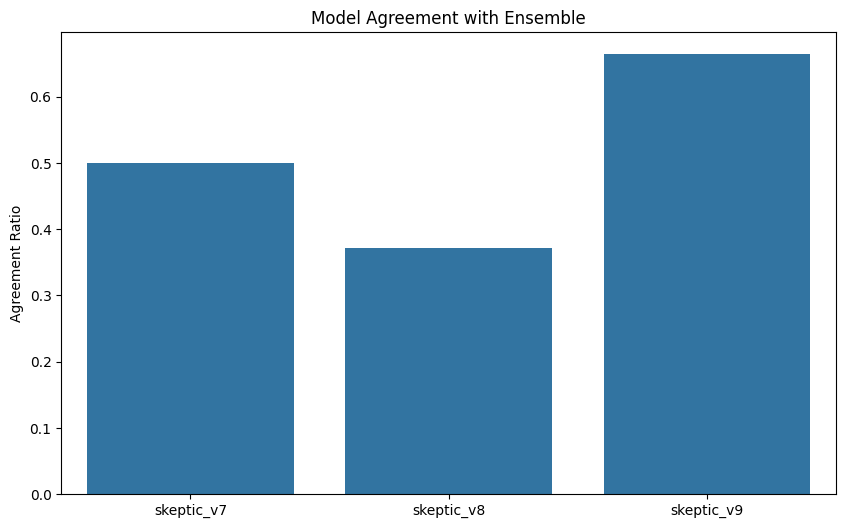

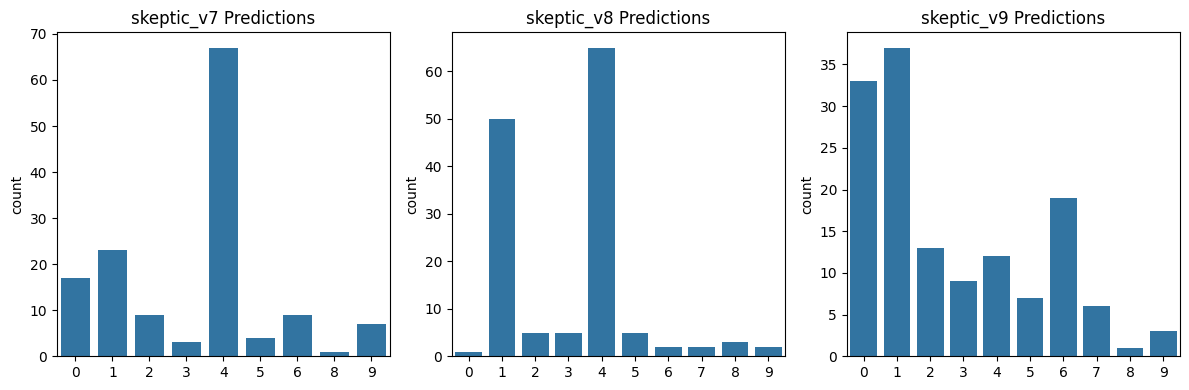

In [42]:
#analyse the predictions
def analyze_predictions(ensemble_pred, individual_preds):
    agreement = (ensemble_pred.unsqueeze(1) == torch.stack(list(individual_preds.values())).T).float().mean(dim=0)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(individual_preds.keys()), y=agreement)
    plt.title('Model Agreement with Ensemble')
    plt.ylabel('Agreement Ratio')
    plt.show()

    # Prediction distribution
    plt.figure(figsize=(12, 4))
    for i, (name, preds) in enumerate(individual_preds.items()):
        plt.subplot(1, 3, i+1)
        sns.countplot(x=preds.numpy())
        plt.title(f'{name} Predictions')
    plt.tight_layout()
    plt.show()

analyze_predictions(ensemble_predictions, individual_predictions)

In [43]:
#overfitting analysis
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def analyze_overfitting(models, train_loader, test_loader):
    results = []
    for name, model in models.items():
        train_acc = evaluate_model(model, train_loader)
        test_acc = evaluate_model(model, test_loader)
        results.append({
            'Model': name,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'Overfitting': train_acc - test_acc
        })
    
    df = pd.DataFrame(results)
    df = df.sort_values('Overfitting', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Overfitting', data=df)
    plt.title('Overfitting Analysis')
    plt.show()
    
    return df

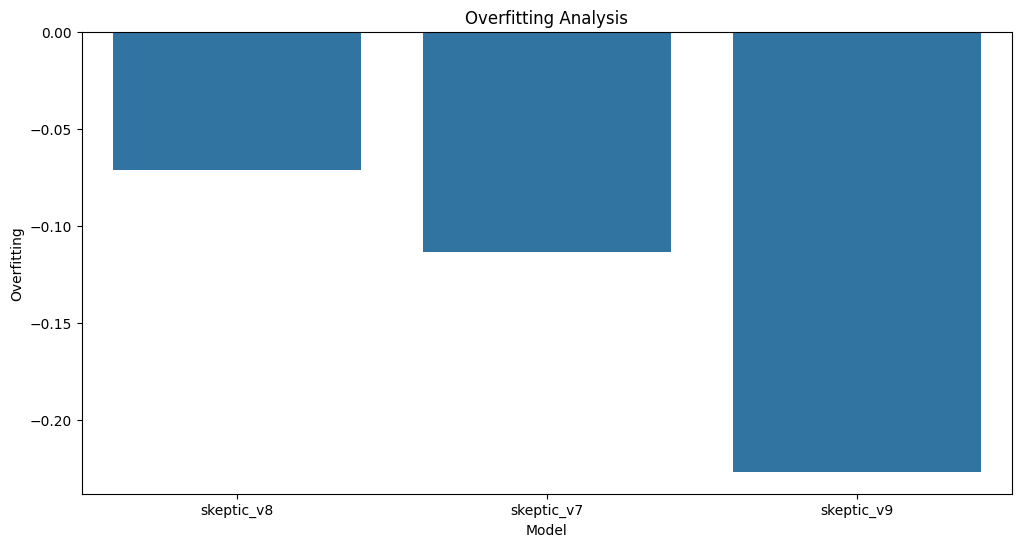

        Model  Train Accuracy  Test Accuracy  Overfitting
1  skeptic_v8        0.128645       0.200000    -0.071355
0  skeptic_v7        0.157774       0.271429    -0.113654
2  skeptic_v9        0.173258       0.400000    -0.226742


In [44]:
# Assuming you have train_loader and test_loader
overfitting_results = analyze_overfitting(
    {'skeptic_v7': skeptic_v7, 'skeptic_v8': skeptic_v8, 'skeptic_v9': skeptic_v9},
    train_loader, test_loader
)
print(overfitting_results)

In [45]:
#model ranking and selection
def rank_models(overfitting_df, test_accuracy_weight=0.7, overfitting_weight=0.3):
    df = overfitting_df.copy()
    df['Score'] = (df['Test Accuracy'] * test_accuracy_weight - 
                   df['Overfitting'] * overfitting_weight)
    return df.sort_values('Score', ascending=False)

ranked_models = rank_models(overfitting_results)
print("Model Ranking:")
print(ranked_models)

# Select the best model type
best_model_type = ranked_models.iloc[0]['Model']
print(f"Best model type: {best_model_type}")

Model Ranking:
        Model  Train Accuracy  Test Accuracy  Overfitting     Score
2  skeptic_v9        0.173258       0.400000    -0.226742  0.348023
0  skeptic_v7        0.157774       0.271429    -0.113654  0.224096
1  skeptic_v8        0.128645       0.200000    -0.071355  0.161406
Best model type: skeptic_v9


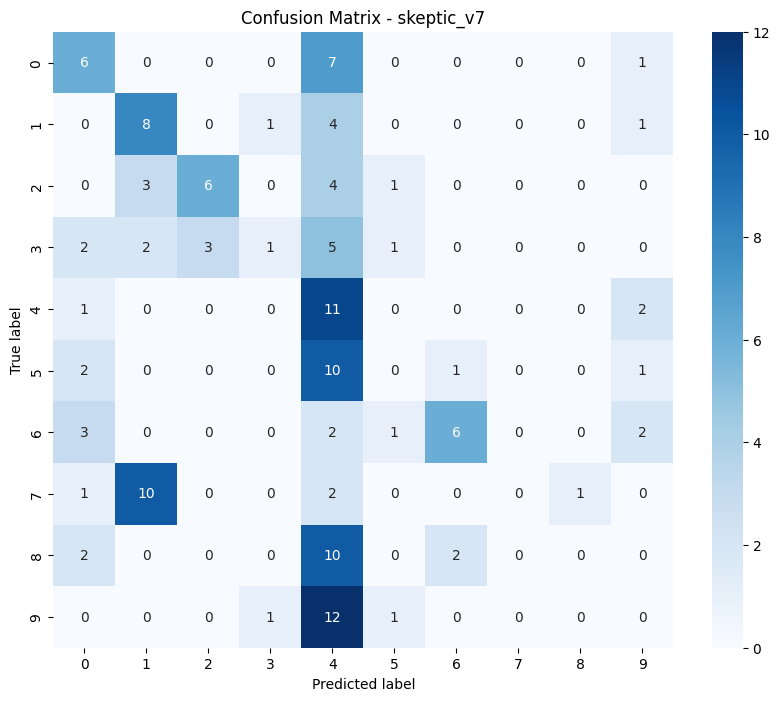

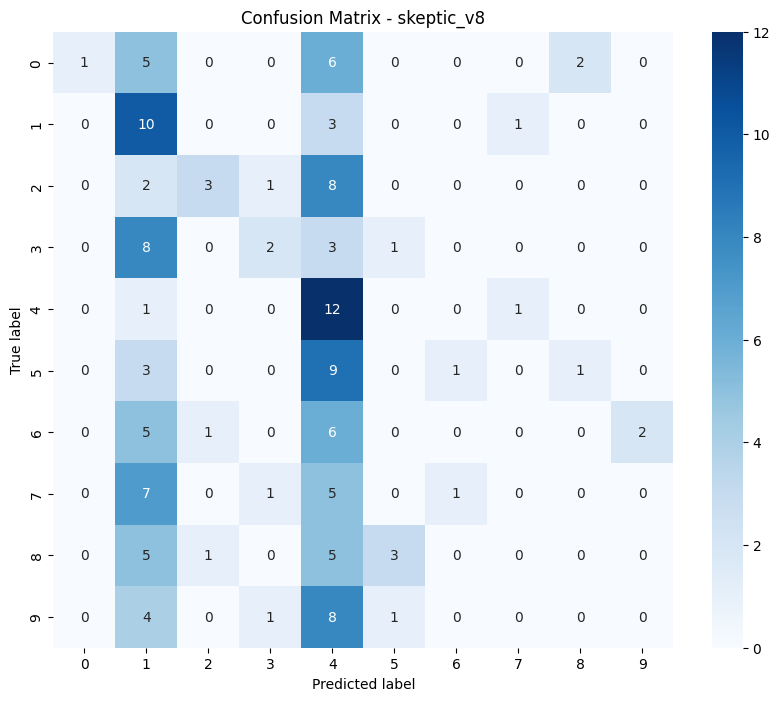

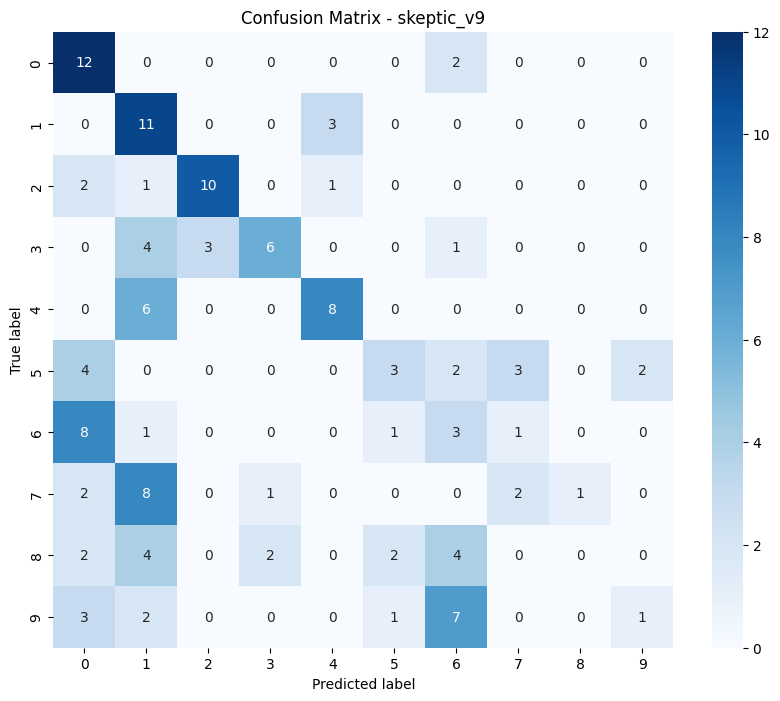

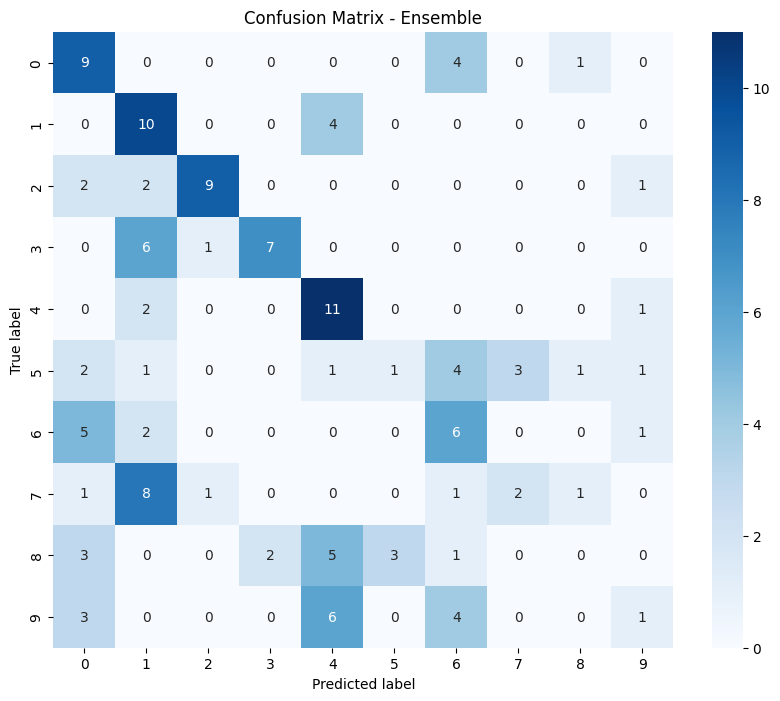

In [46]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get predictions for each model
models = {'skeptic_v7': skeptic_v7, 'skeptic_v8': skeptic_v8, 'skeptic_v9': skeptic_v9}
predictions = {}
for name, model in models.items():
    predictions[name] = get_predictions(model, test_loader)

# Get ensemble predictions
ensemble_preds, true_labels = predict_ensemble(ensemble, test_loader)
ensemble_preds = ensemble_preds.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# Plot confusion matrix for each model
for name, (preds, labels) in predictions.items():
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, f'Confusion Matrix - {name}')

# Plot confusion matrix for ensemble
cm_ensemble = confusion_matrix(true_labels, ensemble_preds)
plot_confusion_matrix(cm_ensemble, 'Confusion Matrix - Ensemble')

# Analyze confusability
def analyze_confusability(cm):
    confusability = cm.sum(axis=0) - np.diag(cm)
    most_confusable = confusability.argmax()
    least_confusable = confusability.argmin()
    return most_confusable, least_confusable

In [47]:
most_confusable, least_confusable = analyze_confusability(cm_ensemble)
print(f"Most confusable digit: {most_confusable}")
print(f"Least confusable (most discriminable) digit: {least_confusable}")

# Analyze misclassifications
misclassifications = cm_ensemble.sum(axis=0) - np.diag(cm_ensemble)
sorted_digits = np.argsort(misclassifications)[::-1]

print("\nDigits ranked by misclassification rate (most to least):")
for digit in sorted_digits:
    print(f"Digit {digit}: {misclassifications[digit]} misclassifications")

Most confusable digit: 1
Least confusable (most discriminable) digit: 2

Digits ranked by misclassification rate (most to least):
Digit 1: 21 misclassifications
Digit 4: 16 misclassifications
Digit 0: 16 misclassifications
Digit 6: 14 misclassifications
Digit 9: 4 misclassifications
Digit 8: 3 misclassifications
Digit 7: 3 misclassifications
Digit 5: 3 misclassifications
Digit 3: 2 misclassifications
Digit 2: 2 misclassifications


TO BE DONE: Once you can do a gladiator clash of the models, you can retrain the best 'type' with different initialisations.

In [ ]:
def create_multiple_models(model_class, num_models=20):
    return [model_class() for _ in range(num_models)]

# Assuming SkepticV7 is the best model type
best_model_class = SkepticV7  # Replace with actual best model class
multiple_models = create_multiple_models(best_model_class)

# Train these models with different initializations
# ... (training code here)

In [ ]:
final_ensemble = ModelEnsemble(multiple_models)

# Evaluate final ensemble
final_predictions = predict_ensemble(final_ensemble, test_data)
final_accuracy = (final_predictions == test_labels).float().mean()
print(f"Final Ensemble Accuracy: {final_accuracy:.4f}")

# Compare with individual model performances
individual_accuracies = [evaluate_model(model, test_data) for model in multiple_models]
plt.figure(figsize=(10, 6))
plt.hist(individual_accuracies, bins=20)
plt.axvline(final_accuracy, color='r', linestyle='dashed', linewidth=2)
plt.title('Individual Model Accuracies vs Ensemble Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(['Ensemble Accuracy', 'Individual Models'])
plt.show()